In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

import tensorflow as tf
import os
import PIL
from tensorflow.keras import layers
from tensorflow import keras
import time

from IPython import display
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/independent_project/

## Create circle dataset

In [ ]:
def gen_circle(n_instance):

    t = np.random.random(size=n_instance) * 2 * np.pi - np.pi
    x_ = np.cos(t)
    y_ = np.sin(t)

    i_set = np.arange(0,n_instance,1)
    for i in i_set:
        length = 1 - np.random.random()*0.4
        x_[i] = x_[i] * length
        y_[i] = y_[i] * length

    X = x_.reshape(-1, 1)
    y = y_.reshape(-1, 1)

    return X, y

In [ ]:
n_instance = 1000
X_train, y_train = gen_circle(n_instance)

In [ ]:
def export_dataset(data, name):
  dataset = pd.DataFrame(data)
  dataset.to_excel(name + '.xlsx',index=False)

In [ ]:
export_dataset(X_train, 'dataset/circle_X_train')
export_dataset(y_train, 'dataset/circle_y_train')

## Import cirlce dataset

In [ ]:
def import_dataset(name):
    data = pd.read_excel(name + '.xlsx')
    return data.iloc[:,:].values

In [ ]:
X_train = import_dataset('dataset/circle_X_train')
y_train = import_dataset('dataset/circle_y_train')

## Preprocess

In [ ]:
BATCH_SIZE = 100
latent_space = 3
train_dataset = np.concatenate((X_train, y_train), axis=1)

(1000, 2)


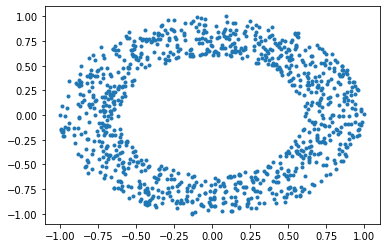

In [ ]:
scaler = MinMaxScaler((-1,1))
train_dataset = scaler.fit_transform(train_dataset)
print(train_dataset.shape)
plt.plot(train_dataset[:,0],train_dataset[:,1],'.' )

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
# for data in train_dataset:
#     print(data)
#     break

## Architecture

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4, use_bias=False, input_shape=(latent_space,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4)))
    
    model.add(layers.Conv1DTranspose(16, kernel_size=1, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv1DTranspose(8, kernel_size=1, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Flatten()) 
    model.add(layers.Dense(2, use_bias=False, activation='tanh'))
    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                48        
_________________________________________________________________
batch_normalization_6 (Batch (None, 16)                64        
_________________________________________________________________
re_lu_3 (ReLU)               (None, 16)                0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4)              0         
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 4, 16)             64        
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 16)             64        
_________________________________________________________________
re_lu_4 (ReLU)               (None, 4, 16)            

In [ ]:
noise = tf.random.normal([1000, latent_space])
generated_image = generator(noise, training=False)
# print(generated_image.shape)
# plt.plot(generated_image[:,0], generated_image[:,1],'.')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4, use_bias=False, input_shape=([2])))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4)))
    
    model.add(layers.Conv1D(16, kernel_size=1, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1D(8, kernel_size=1, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                32        
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 16)             80        
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 16)             64        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 16)            

In [ ]:
# decision = discriminator(generated_image)
# print (decision)

## Train

In [ ]:
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [ ]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, latent_space])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    generator_mean_loss(gen_loss)
    discriminator_mean_loss(disc_loss)

In [ ]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:
            train_step(batch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()

        if epoch%100 == 0: 
            generated_image = generator(noise, training=False)
            #print(generated_image.shape)
            plt.plot(generated_image[:,0], generated_image[:,1],'.')
  
            # Save model
            # gan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    
            
            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            ax.set_yscale('log')
            ax.grid()
            plt.show()
            
    return hist

Epoch 1/2000
Loss: 


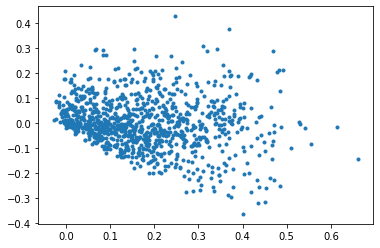

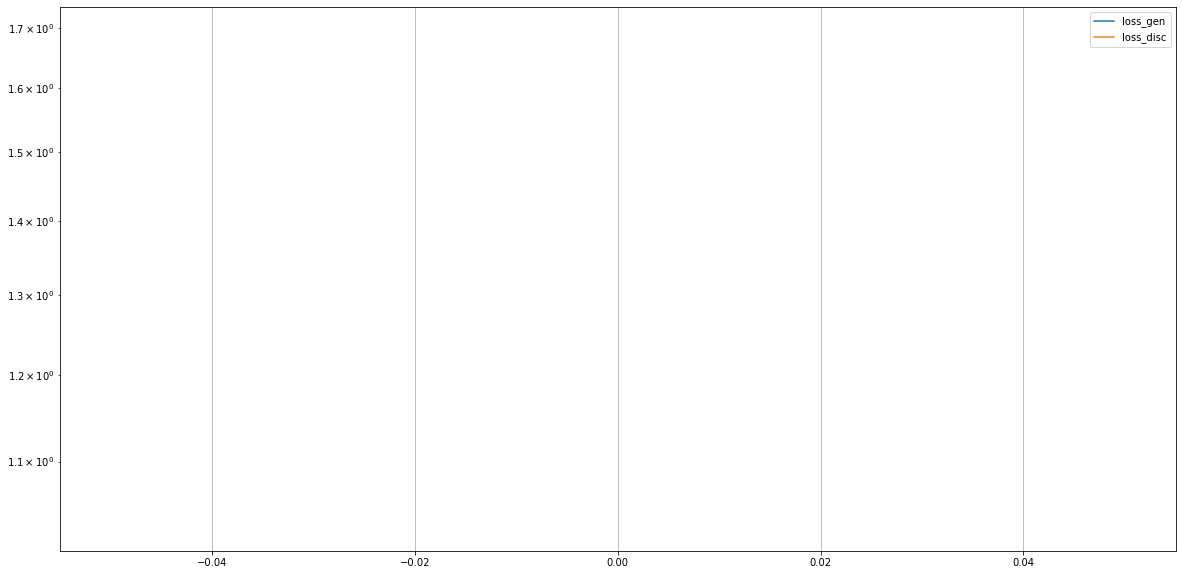

Epoch 2/2000
Epoch 3/2000
Epoch 4/2000
Epoch 5/2000
Epoch 6/2000
Epoch 7/2000
Epoch 8/2000
Epoch 9/2000
Epoch 10/2000
Epoch 11/2000
Epoch 12/2000
Epoch 13/2000
Epoch 14/2000
Epoch 15/2000
Epoch 16/2000
Epoch 17/2000
Epoch 18/2000
Epoch 19/2000
Epoch 20/2000
Epoch 21/2000
Epoch 22/2000
Epoch 23/2000
Epoch 24/2000
Epoch 25/2000
Epoch 26/2000
Epoch 27/2000
Epoch 28/2000
Epoch 29/2000
Epoch 30/2000
Epoch 31/2000
Epoch 32/2000
Epoch 33/2000
Epoch 34/2000
Epoch 35/2000
Epoch 36/2000
Epoch 37/2000
Epoch 38/2000
Epoch 39/2000
Epoch 40/2000
Epoch 41/2000
Epoch 42/2000
Epoch 43/2000
Epoch 44/2000
Epoch 45/2000
Epoch 46/2000
Epoch 47/2000
Epoch 48/2000
Epoch 49/2000
Epoch 50/2000
Epoch 51/2000
Epoch 52/2000
Epoch 53/2000
Epoch 54/2000
Epoch 55/2000
Epoch 56/2000
Epoch 57/2000
Epoch 58/2000
Epoch 59/2000
Epoch 60/2000
Epoch 61/2000
Epoch 62/2000
Epoch 63/2000
Epoch 64/2000
Epoch 65/2000
Epoch 66/2000
Epoch 67/2000
Epoch 68/2000
Epoch 69/2000
Epoch 70/2000
Epoch 71/2000
Epoch 72/2000
Epoch 73/2000


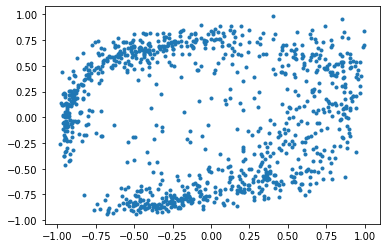

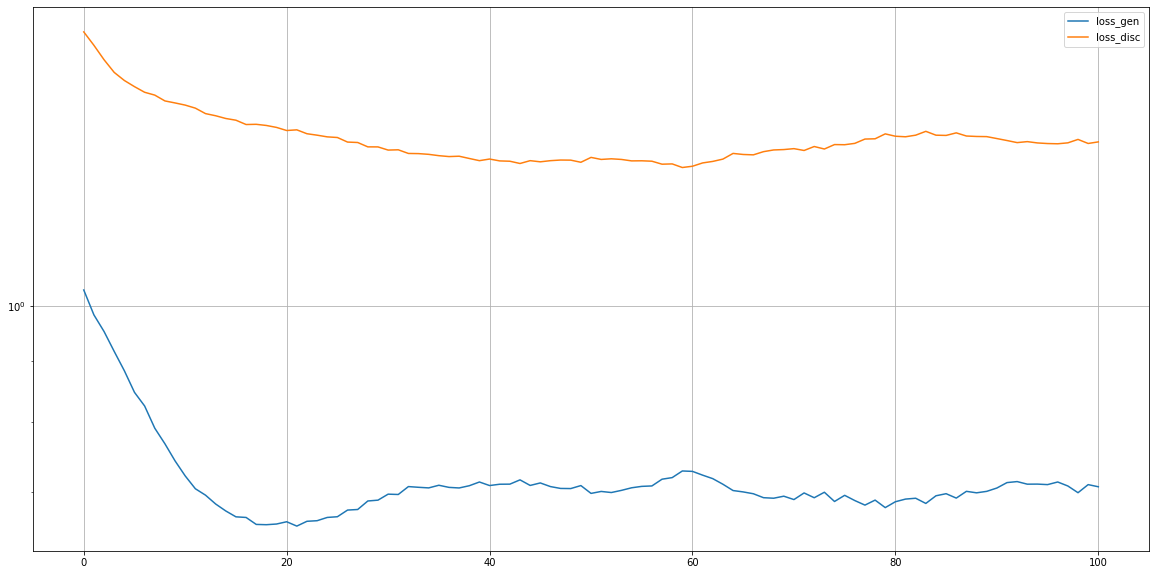

Epoch 102/2000
Epoch 103/2000
Epoch 104/2000
Epoch 105/2000
Epoch 106/2000
Epoch 107/2000
Epoch 108/2000
Epoch 109/2000
Epoch 110/2000
Epoch 111/2000
Epoch 112/2000
Epoch 113/2000
Epoch 114/2000
Epoch 115/2000
Epoch 116/2000
Epoch 117/2000
Epoch 118/2000
Epoch 119/2000
Epoch 120/2000
Epoch 121/2000
Epoch 122/2000
Epoch 123/2000
Epoch 124/2000
Epoch 125/2000
Epoch 126/2000
Epoch 127/2000
Epoch 128/2000
Epoch 129/2000
Epoch 130/2000
Epoch 131/2000
Epoch 132/2000
Epoch 133/2000
Epoch 134/2000
Epoch 135/2000
Epoch 136/2000
Epoch 137/2000
Epoch 138/2000
Epoch 139/2000
Epoch 140/2000
Epoch 141/2000
Epoch 142/2000
Epoch 143/2000
Epoch 144/2000
Epoch 145/2000
Epoch 146/2000
Epoch 147/2000
Epoch 148/2000
Epoch 149/2000
Epoch 150/2000
Epoch 151/2000
Epoch 152/2000
Epoch 153/2000
Epoch 154/2000
Epoch 155/2000
Epoch 156/2000
Epoch 157/2000
Epoch 158/2000
Epoch 159/2000
Epoch 160/2000
Epoch 161/2000
Epoch 162/2000
Epoch 163/2000
Epoch 164/2000
Epoch 165/2000
Epoch 166/2000
Epoch 167/2000
Epoch 168/

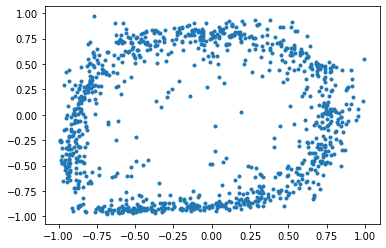

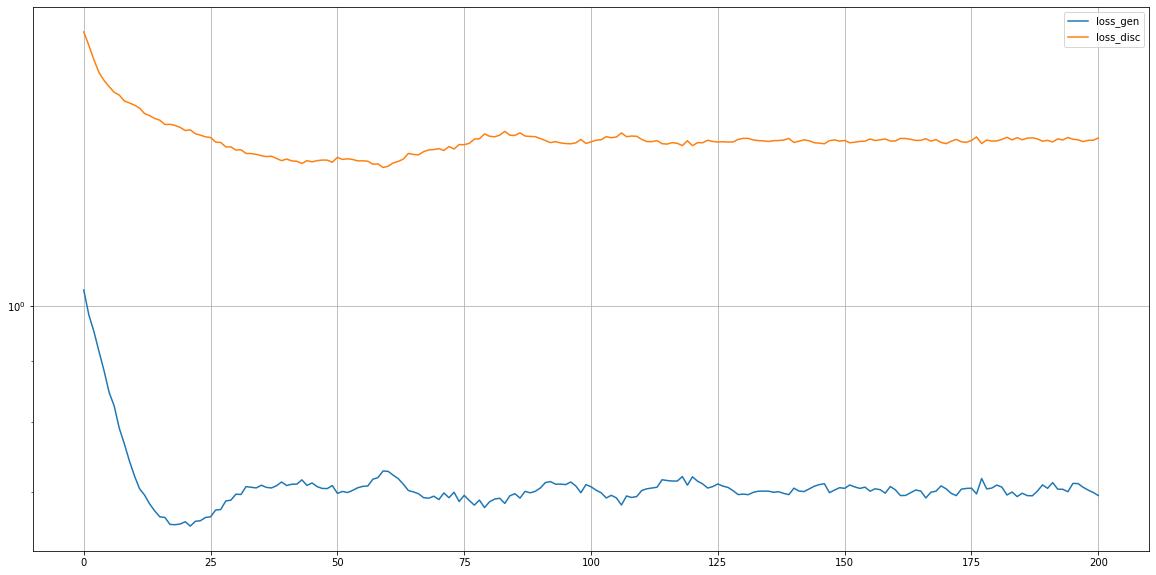

Epoch 202/2000
Epoch 203/2000
Epoch 204/2000
Epoch 205/2000
Epoch 206/2000
Epoch 207/2000
Epoch 208/2000
Epoch 209/2000
Epoch 210/2000
Epoch 211/2000
Epoch 212/2000
Epoch 213/2000
Epoch 214/2000
Epoch 215/2000
Epoch 216/2000
Epoch 217/2000
Epoch 218/2000
Epoch 219/2000
Epoch 220/2000
Epoch 221/2000
Epoch 222/2000
Epoch 223/2000
Epoch 224/2000
Epoch 225/2000
Epoch 226/2000
Epoch 227/2000
Epoch 228/2000
Epoch 229/2000
Epoch 230/2000
Epoch 231/2000
Epoch 232/2000
Epoch 233/2000
Epoch 234/2000
Epoch 235/2000
Epoch 236/2000
Epoch 237/2000
Epoch 238/2000
Epoch 239/2000
Epoch 240/2000
Epoch 241/2000
Epoch 242/2000
Epoch 243/2000
Epoch 244/2000
Epoch 245/2000
Epoch 246/2000
Epoch 247/2000
Epoch 248/2000
Epoch 249/2000
Epoch 250/2000
Epoch 251/2000
Epoch 252/2000
Epoch 253/2000
Epoch 254/2000
Epoch 255/2000
Epoch 256/2000
Epoch 257/2000
Epoch 258/2000
Epoch 259/2000
Epoch 260/2000
Epoch 261/2000
Epoch 262/2000
Epoch 263/2000
Epoch 264/2000
Epoch 265/2000
Epoch 266/2000
Epoch 267/2000
Epoch 268/

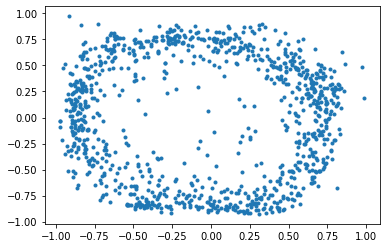

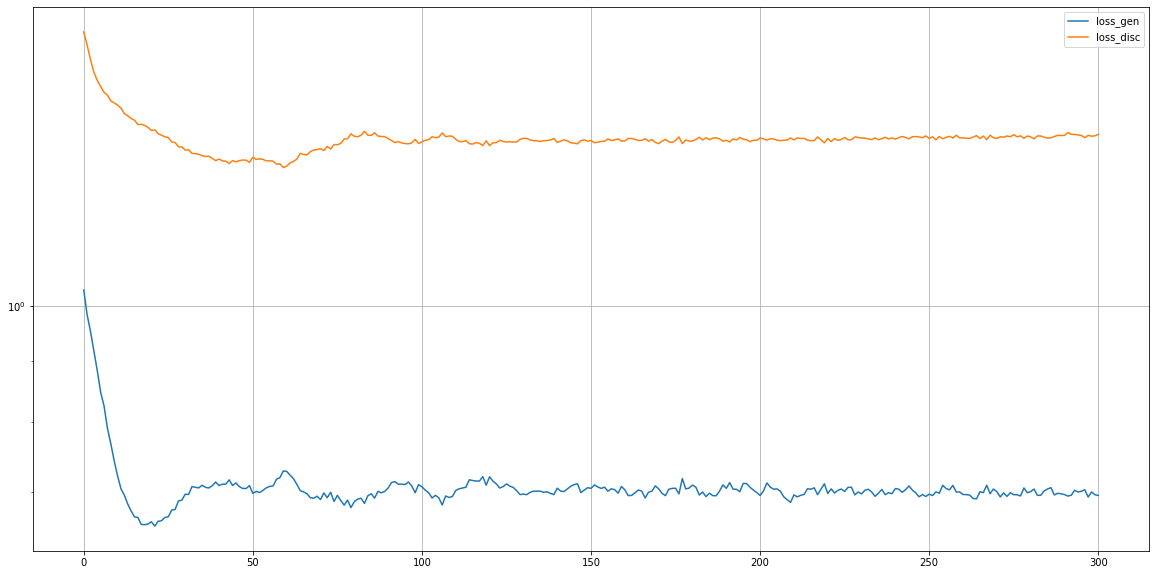

Epoch 302/2000
Epoch 303/2000
Epoch 304/2000
Epoch 305/2000
Epoch 306/2000
Epoch 307/2000
Epoch 308/2000
Epoch 309/2000
Epoch 310/2000
Epoch 311/2000
Epoch 312/2000
Epoch 313/2000
Epoch 314/2000
Epoch 315/2000
Epoch 316/2000
Epoch 317/2000
Epoch 318/2000
Epoch 319/2000
Epoch 320/2000
Epoch 321/2000
Epoch 322/2000
Epoch 323/2000
Epoch 324/2000
Epoch 325/2000
Epoch 326/2000
Epoch 327/2000
Epoch 328/2000
Epoch 329/2000
Epoch 330/2000
Epoch 331/2000
Epoch 332/2000
Epoch 333/2000
Epoch 334/2000
Epoch 335/2000
Epoch 336/2000
Epoch 337/2000
Epoch 338/2000
Epoch 339/2000
Epoch 340/2000
Epoch 341/2000
Epoch 342/2000
Epoch 343/2000
Epoch 344/2000
Epoch 345/2000
Epoch 346/2000
Epoch 347/2000
Epoch 348/2000
Epoch 349/2000
Epoch 350/2000
Epoch 351/2000
Epoch 352/2000
Epoch 353/2000
Epoch 354/2000
Epoch 355/2000
Epoch 356/2000
Epoch 357/2000
Epoch 358/2000
Epoch 359/2000
Epoch 360/2000
Epoch 361/2000
Epoch 362/2000
Epoch 363/2000
Epoch 364/2000
Epoch 365/2000
Epoch 366/2000
Epoch 367/2000
Epoch 368/

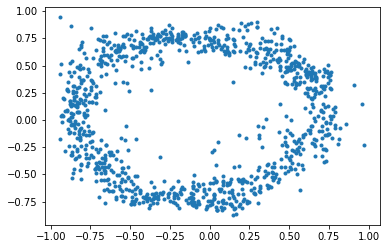

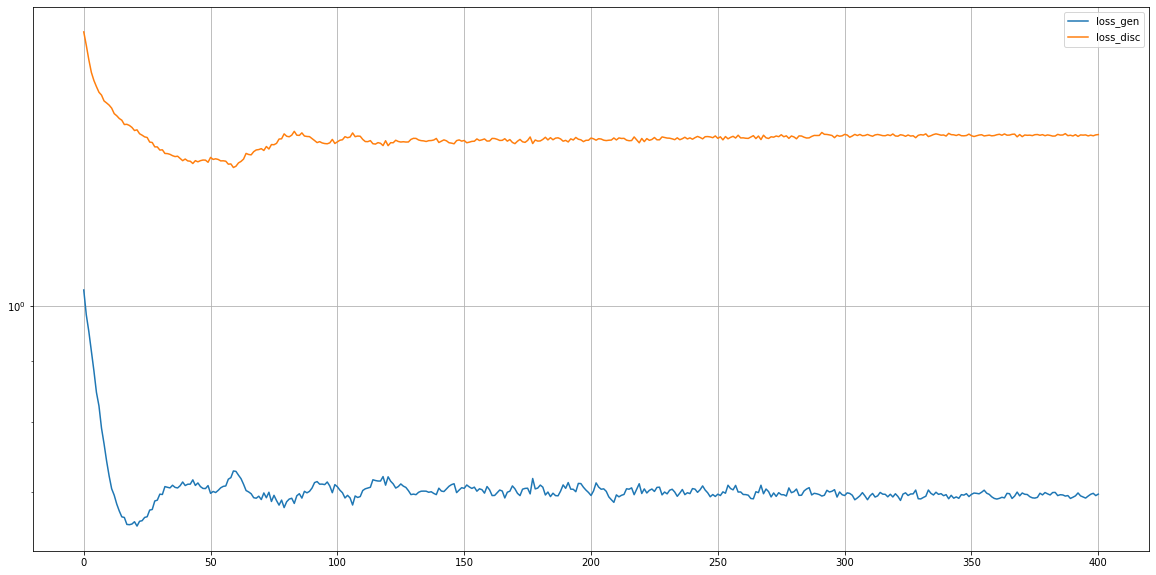

Epoch 402/2000
Epoch 403/2000
Epoch 404/2000
Epoch 405/2000
Epoch 406/2000
Epoch 407/2000
Epoch 408/2000
Epoch 409/2000
Epoch 410/2000
Epoch 411/2000
Epoch 412/2000
Epoch 413/2000
Epoch 414/2000
Epoch 415/2000
Epoch 416/2000
Epoch 417/2000
Epoch 418/2000
Epoch 419/2000
Epoch 420/2000
Epoch 421/2000
Epoch 422/2000
Epoch 423/2000
Epoch 424/2000
Epoch 425/2000
Epoch 426/2000
Epoch 427/2000
Epoch 428/2000
Epoch 429/2000
Epoch 430/2000
Epoch 431/2000
Epoch 432/2000
Epoch 433/2000
Epoch 434/2000
Epoch 435/2000
Epoch 436/2000
Epoch 437/2000
Epoch 438/2000
Epoch 439/2000
Epoch 440/2000
Epoch 441/2000
Epoch 442/2000
Epoch 443/2000
Epoch 444/2000
Epoch 445/2000
Epoch 446/2000
Epoch 447/2000
Epoch 448/2000
Epoch 449/2000
Epoch 450/2000
Epoch 451/2000
Epoch 452/2000
Epoch 453/2000
Epoch 454/2000
Epoch 455/2000
Epoch 456/2000
Epoch 457/2000
Epoch 458/2000
Epoch 459/2000
Epoch 460/2000
Epoch 461/2000
Epoch 462/2000
Epoch 463/2000
Epoch 464/2000
Epoch 465/2000
Epoch 466/2000
Epoch 467/2000
Epoch 468/

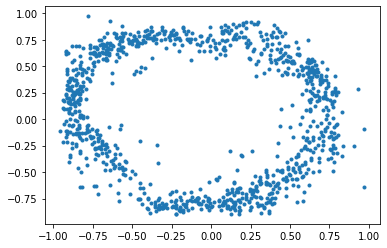

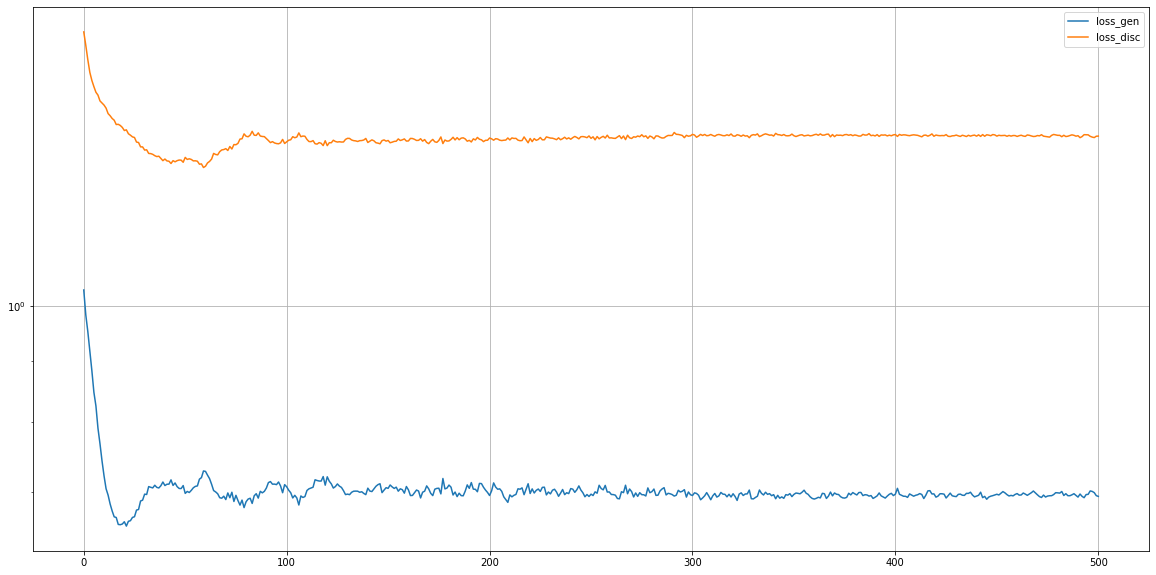

Epoch 502/2000
Epoch 503/2000
Epoch 504/2000
Epoch 505/2000
Epoch 506/2000
Epoch 507/2000
Epoch 508/2000
Epoch 509/2000
Epoch 510/2000
Epoch 511/2000
Epoch 512/2000
Epoch 513/2000
Epoch 514/2000
Epoch 515/2000
Epoch 516/2000
Epoch 517/2000
Epoch 518/2000
Epoch 519/2000
Epoch 520/2000
Epoch 521/2000
Epoch 522/2000
Epoch 523/2000
Epoch 524/2000
Epoch 525/2000
Epoch 526/2000
Epoch 527/2000
Epoch 528/2000
Epoch 529/2000
Epoch 530/2000
Epoch 531/2000
Epoch 532/2000
Epoch 533/2000
Epoch 534/2000
Epoch 535/2000
Epoch 536/2000
Epoch 537/2000
Epoch 538/2000
Epoch 539/2000
Epoch 540/2000
Epoch 541/2000
Epoch 542/2000
Epoch 543/2000
Epoch 544/2000
Epoch 545/2000
Epoch 546/2000
Epoch 547/2000
Epoch 548/2000
Epoch 549/2000
Epoch 550/2000
Epoch 551/2000
Epoch 552/2000
Epoch 553/2000
Epoch 554/2000
Epoch 555/2000
Epoch 556/2000
Epoch 557/2000
Epoch 558/2000
Epoch 559/2000
Epoch 560/2000
Epoch 561/2000
Epoch 562/2000
Epoch 563/2000
Epoch 564/2000
Epoch 565/2000
Epoch 566/2000
Epoch 567/2000
Epoch 568/

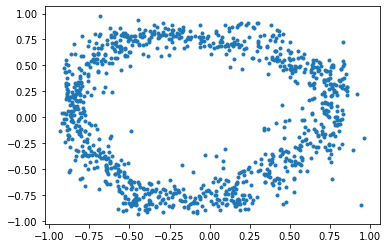

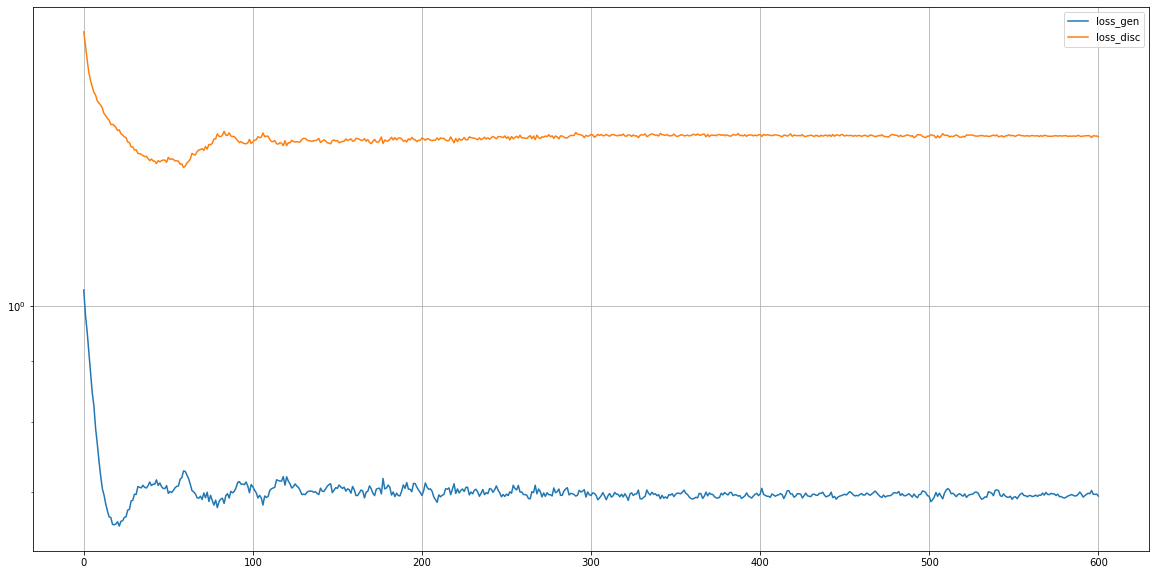

Epoch 602/2000
Epoch 603/2000
Epoch 604/2000
Epoch 605/2000
Epoch 606/2000
Epoch 607/2000
Epoch 608/2000
Epoch 609/2000
Epoch 610/2000
Epoch 611/2000
Epoch 612/2000
Epoch 613/2000
Epoch 614/2000
Epoch 615/2000
Epoch 616/2000
Epoch 617/2000
Epoch 618/2000
Epoch 619/2000
Epoch 620/2000
Epoch 621/2000
Epoch 622/2000
Epoch 623/2000
Epoch 624/2000
Epoch 625/2000
Epoch 626/2000
Epoch 627/2000
Epoch 628/2000
Epoch 629/2000
Epoch 630/2000
Epoch 631/2000
Epoch 632/2000
Epoch 633/2000
Epoch 634/2000
Epoch 635/2000
Epoch 636/2000
Epoch 637/2000
Epoch 638/2000
Epoch 639/2000
Epoch 640/2000
Epoch 641/2000
Epoch 642/2000
Epoch 643/2000
Epoch 644/2000
Epoch 645/2000
Epoch 646/2000
Epoch 647/2000
Epoch 648/2000
Epoch 649/2000
Epoch 650/2000
Epoch 651/2000
Epoch 652/2000
Epoch 653/2000
Epoch 654/2000
Epoch 655/2000
Epoch 656/2000
Epoch 657/2000
Epoch 658/2000
Epoch 659/2000
Epoch 660/2000
Epoch 661/2000
Epoch 662/2000
Epoch 663/2000
Epoch 664/2000
Epoch 665/2000
Epoch 666/2000
Epoch 667/2000
Epoch 668/

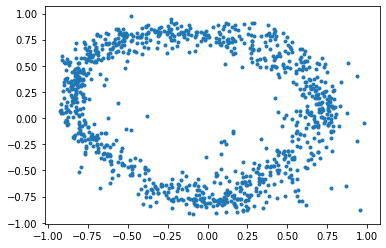

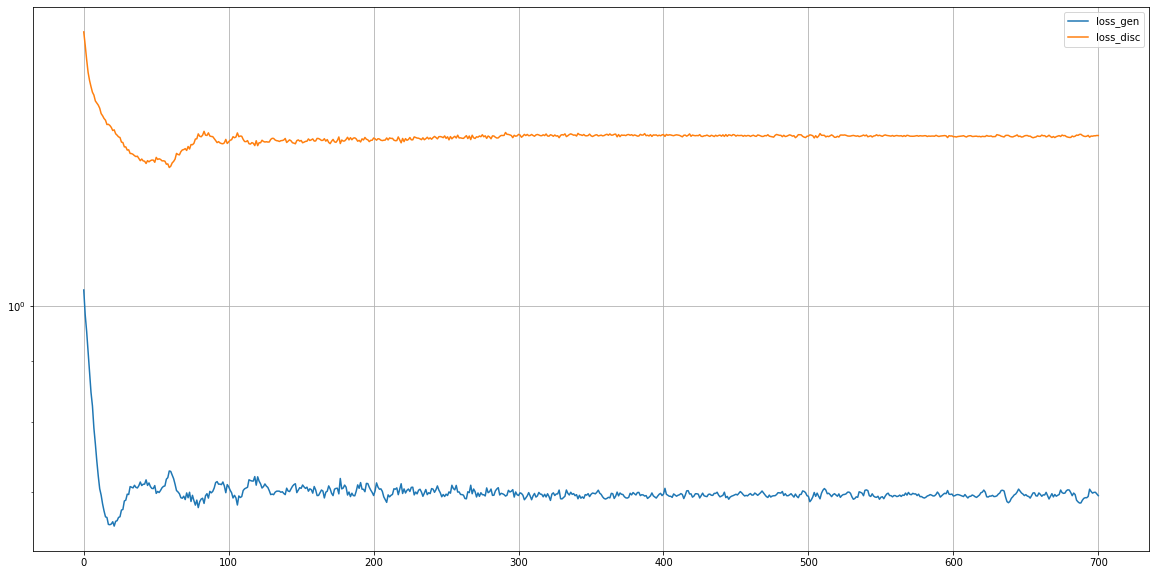

Epoch 702/2000
Epoch 703/2000
Epoch 704/2000
Epoch 705/2000
Epoch 706/2000
Epoch 707/2000
Epoch 708/2000
Epoch 709/2000
Epoch 710/2000
Epoch 711/2000
Epoch 712/2000
Epoch 713/2000
Epoch 714/2000
Epoch 715/2000
Epoch 716/2000
Epoch 717/2000
Epoch 718/2000
Epoch 719/2000
Epoch 720/2000
Epoch 721/2000
Epoch 722/2000
Epoch 723/2000
Epoch 724/2000
Epoch 725/2000
Epoch 726/2000
Epoch 727/2000
Epoch 728/2000
Epoch 729/2000
Epoch 730/2000
Epoch 731/2000
Epoch 732/2000
Epoch 733/2000
Epoch 734/2000
Epoch 735/2000
Epoch 736/2000
Epoch 737/2000
Epoch 738/2000
Epoch 739/2000
Epoch 740/2000
Epoch 741/2000
Epoch 742/2000
Epoch 743/2000
Epoch 744/2000
Epoch 745/2000
Epoch 746/2000
Epoch 747/2000
Epoch 748/2000
Epoch 749/2000
Epoch 750/2000
Epoch 751/2000
Epoch 752/2000
Epoch 753/2000
Epoch 754/2000
Epoch 755/2000
Epoch 756/2000
Epoch 757/2000
Epoch 758/2000
Epoch 759/2000
Epoch 760/2000
Epoch 761/2000
Epoch 762/2000
Epoch 763/2000
Epoch 764/2000
Epoch 765/2000
Epoch 766/2000
Epoch 767/2000
Epoch 768/

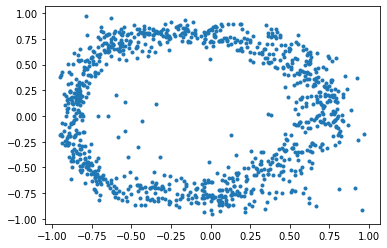

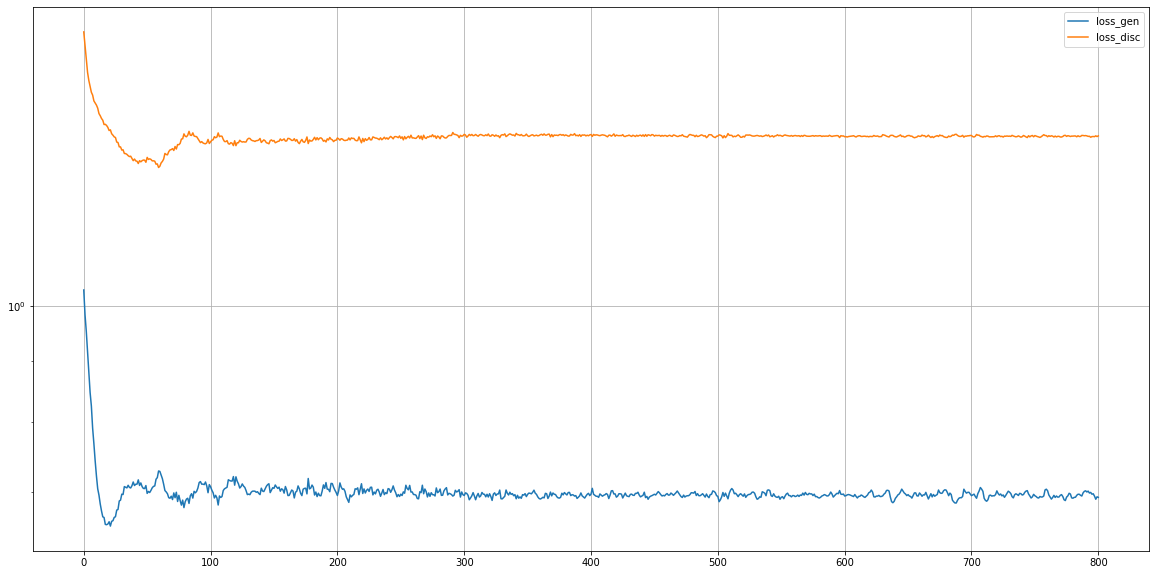

Epoch 802/2000
Epoch 803/2000
Epoch 804/2000
Epoch 805/2000
Epoch 806/2000
Epoch 807/2000
Epoch 808/2000
Epoch 809/2000
Epoch 810/2000
Epoch 811/2000
Epoch 812/2000
Epoch 813/2000
Epoch 814/2000
Epoch 815/2000
Epoch 816/2000
Epoch 817/2000
Epoch 818/2000
Epoch 819/2000
Epoch 820/2000
Epoch 821/2000
Epoch 822/2000
Epoch 823/2000
Epoch 824/2000
Epoch 825/2000
Epoch 826/2000
Epoch 827/2000
Epoch 828/2000
Epoch 829/2000
Epoch 830/2000
Epoch 831/2000
Epoch 832/2000
Epoch 833/2000
Epoch 834/2000
Epoch 835/2000
Epoch 836/2000
Epoch 837/2000
Epoch 838/2000
Epoch 839/2000
Epoch 840/2000
Epoch 841/2000
Epoch 842/2000
Epoch 843/2000
Epoch 844/2000
Epoch 845/2000
Epoch 846/2000
Epoch 847/2000
Epoch 848/2000
Epoch 849/2000
Epoch 850/2000
Epoch 851/2000
Epoch 852/2000
Epoch 853/2000
Epoch 854/2000
Epoch 855/2000
Epoch 856/2000
Epoch 857/2000
Epoch 858/2000
Epoch 859/2000
Epoch 860/2000
Epoch 861/2000
Epoch 862/2000
Epoch 863/2000
Epoch 864/2000
Epoch 865/2000
Epoch 866/2000
Epoch 867/2000
Epoch 868/

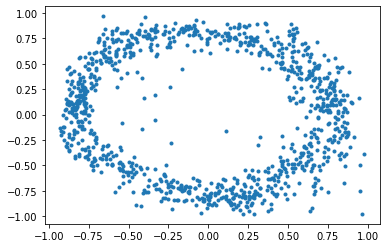

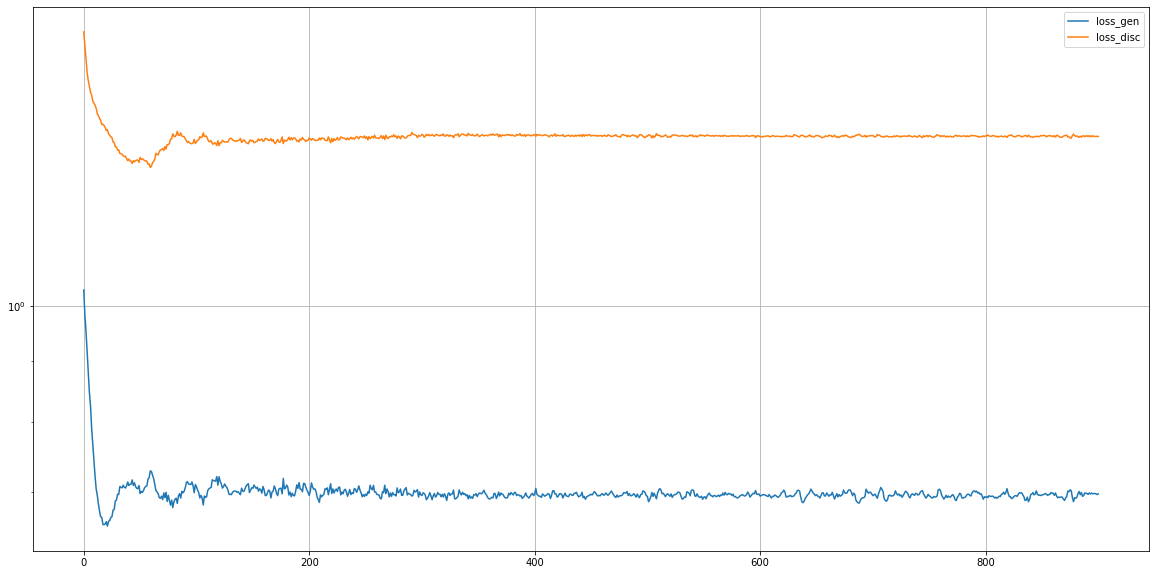

Epoch 902/2000
Epoch 903/2000
Epoch 904/2000
Epoch 905/2000
Epoch 906/2000
Epoch 907/2000
Epoch 908/2000
Epoch 909/2000
Epoch 910/2000
Epoch 911/2000
Epoch 912/2000
Epoch 913/2000
Epoch 914/2000
Epoch 915/2000
Epoch 916/2000
Epoch 917/2000
Epoch 918/2000
Epoch 919/2000
Epoch 920/2000
Epoch 921/2000
Epoch 922/2000
Epoch 923/2000
Epoch 924/2000
Epoch 925/2000
Epoch 926/2000
Epoch 927/2000
Epoch 928/2000
Epoch 929/2000
Epoch 930/2000
Epoch 931/2000
Epoch 932/2000
Epoch 933/2000
Epoch 934/2000
Epoch 935/2000
Epoch 936/2000
Epoch 937/2000
Epoch 938/2000
Epoch 939/2000
Epoch 940/2000
Epoch 941/2000
Epoch 942/2000
Epoch 943/2000
Epoch 944/2000
Epoch 945/2000
Epoch 946/2000
Epoch 947/2000
Epoch 948/2000
Epoch 949/2000
Epoch 950/2000
Epoch 951/2000
Epoch 952/2000
Epoch 953/2000
Epoch 954/2000
Epoch 955/2000
Epoch 956/2000
Epoch 957/2000
Epoch 958/2000
Epoch 959/2000
Epoch 960/2000
Epoch 961/2000
Epoch 962/2000
Epoch 963/2000
Epoch 964/2000
Epoch 965/2000
Epoch 966/2000
Epoch 967/2000
Epoch 968/

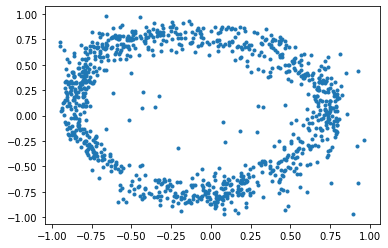

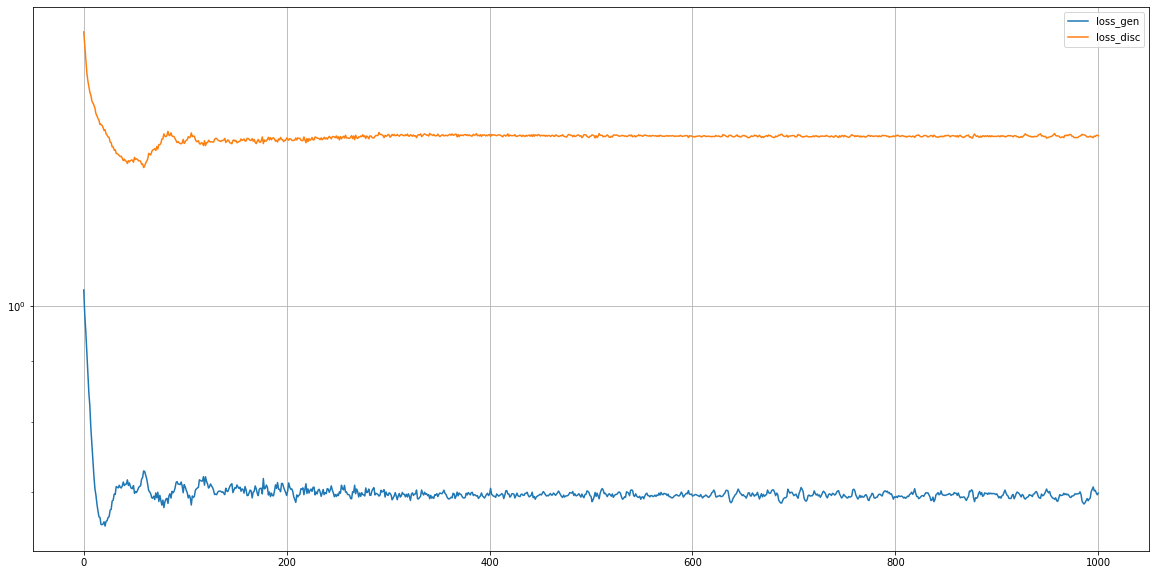

Epoch 1002/2000
Epoch 1003/2000
Epoch 1004/2000
Epoch 1005/2000
Epoch 1006/2000
Epoch 1007/2000
Epoch 1008/2000
Epoch 1009/2000
Epoch 1010/2000
Epoch 1011/2000
Epoch 1012/2000
Epoch 1013/2000
Epoch 1014/2000
Epoch 1015/2000
Epoch 1016/2000
Epoch 1017/2000
Epoch 1018/2000
Epoch 1019/2000
Epoch 1020/2000
Epoch 1021/2000
Epoch 1022/2000
Epoch 1023/2000
Epoch 1024/2000
Epoch 1025/2000
Epoch 1026/2000
Epoch 1027/2000
Epoch 1028/2000
Epoch 1029/2000
Epoch 1030/2000
Epoch 1031/2000
Epoch 1032/2000
Epoch 1033/2000
Epoch 1034/2000
Epoch 1035/2000
Epoch 1036/2000
Epoch 1037/2000
Epoch 1038/2000
Epoch 1039/2000
Epoch 1040/2000
Epoch 1041/2000
Epoch 1042/2000
Epoch 1043/2000
Epoch 1044/2000
Epoch 1045/2000
Epoch 1046/2000
Epoch 1047/2000
Epoch 1048/2000
Epoch 1049/2000
Epoch 1050/2000
Epoch 1051/2000
Epoch 1052/2000
Epoch 1053/2000
Epoch 1054/2000
Epoch 1055/2000
Epoch 1056/2000
Epoch 1057/2000
Epoch 1058/2000
Epoch 1059/2000
Epoch 1060/2000
Epoch 1061/2000
Epoch 1062/2000
Epoch 1063/2000
Epoch 10

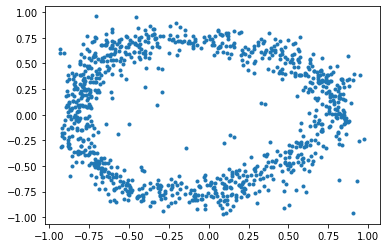

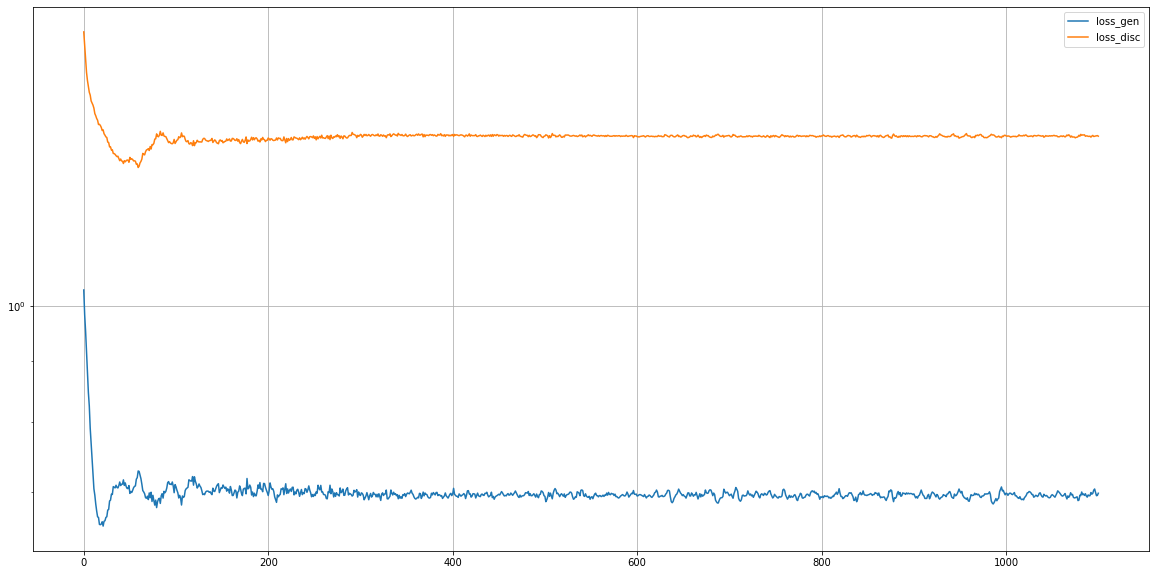

Epoch 1102/2000
Epoch 1103/2000
Epoch 1104/2000
Epoch 1105/2000
Epoch 1106/2000
Epoch 1107/2000
Epoch 1108/2000
Epoch 1109/2000
Epoch 1110/2000
Epoch 1111/2000
Epoch 1112/2000
Epoch 1113/2000
Epoch 1114/2000
Epoch 1115/2000
Epoch 1116/2000
Epoch 1117/2000
Epoch 1118/2000
Epoch 1119/2000
Epoch 1120/2000
Epoch 1121/2000
Epoch 1122/2000
Epoch 1123/2000
Epoch 1124/2000
Epoch 1125/2000
Epoch 1126/2000
Epoch 1127/2000
Epoch 1128/2000
Epoch 1129/2000
Epoch 1130/2000
Epoch 1131/2000
Epoch 1132/2000
Epoch 1133/2000
Epoch 1134/2000
Epoch 1135/2000
Epoch 1136/2000
Epoch 1137/2000
Epoch 1138/2000
Epoch 1139/2000
Epoch 1140/2000
Epoch 1141/2000
Epoch 1142/2000
Epoch 1143/2000
Epoch 1144/2000
Epoch 1145/2000
Epoch 1146/2000
Epoch 1147/2000
Epoch 1148/2000
Epoch 1149/2000
Epoch 1150/2000
Epoch 1151/2000
Epoch 1152/2000
Epoch 1153/2000
Epoch 1154/2000
Epoch 1155/2000
Epoch 1156/2000
Epoch 1157/2000
Epoch 1158/2000
Epoch 1159/2000
Epoch 1160/2000
Epoch 1161/2000
Epoch 1162/2000
Epoch 1163/2000
Epoch 11

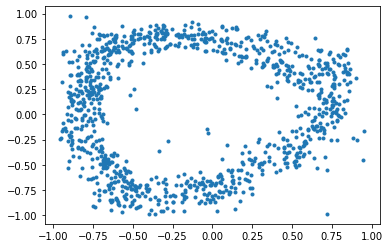

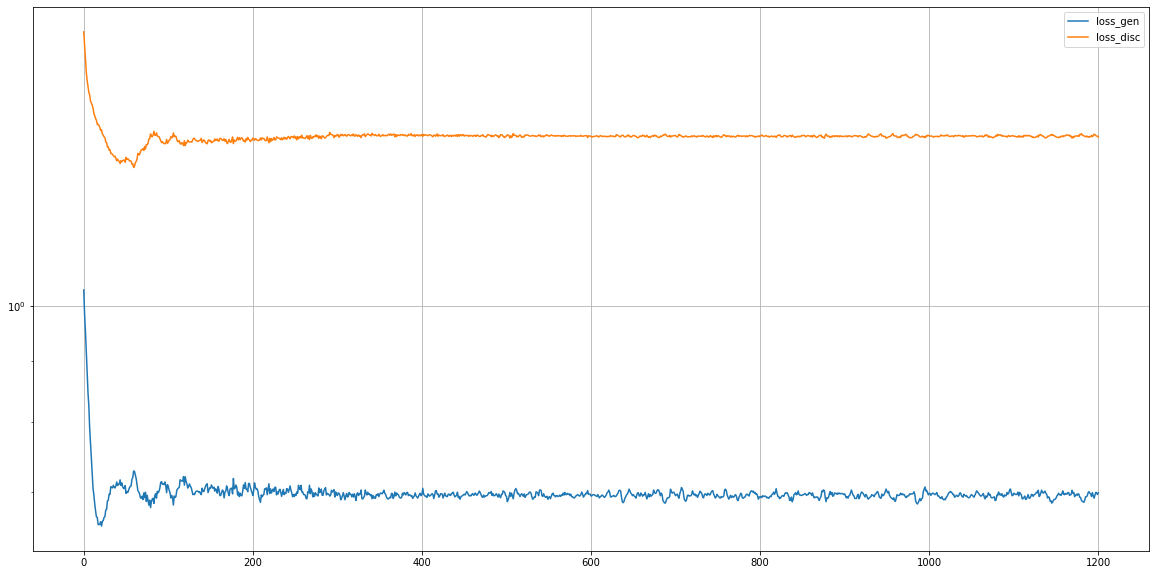

Epoch 1202/2000
Epoch 1203/2000
Epoch 1204/2000
Epoch 1205/2000
Epoch 1206/2000
Epoch 1207/2000
Epoch 1208/2000
Epoch 1209/2000
Epoch 1210/2000
Epoch 1211/2000
Epoch 1212/2000
Epoch 1213/2000
Epoch 1214/2000
Epoch 1215/2000
Epoch 1216/2000
Epoch 1217/2000
Epoch 1218/2000
Epoch 1219/2000
Epoch 1220/2000
Epoch 1221/2000
Epoch 1222/2000
Epoch 1223/2000
Epoch 1224/2000
Epoch 1225/2000
Epoch 1226/2000
Epoch 1227/2000
Epoch 1228/2000
Epoch 1229/2000
Epoch 1230/2000
Epoch 1231/2000
Epoch 1232/2000
Epoch 1233/2000
Epoch 1234/2000
Epoch 1235/2000
Epoch 1236/2000
Epoch 1237/2000
Epoch 1238/2000
Epoch 1239/2000
Epoch 1240/2000
Epoch 1241/2000
Epoch 1242/2000
Epoch 1243/2000
Epoch 1244/2000
Epoch 1245/2000
Epoch 1246/2000
Epoch 1247/2000
Epoch 1248/2000
Epoch 1249/2000
Epoch 1250/2000
Epoch 1251/2000
Epoch 1252/2000
Epoch 1253/2000
Epoch 1254/2000
Epoch 1255/2000
Epoch 1256/2000
Epoch 1257/2000
Epoch 1258/2000
Epoch 1259/2000
Epoch 1260/2000
Epoch 1261/2000
Epoch 1262/2000
Epoch 1263/2000
Epoch 12

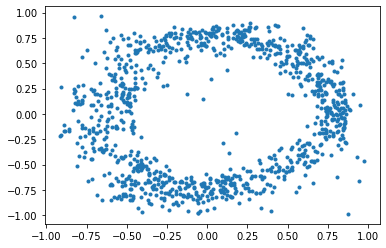

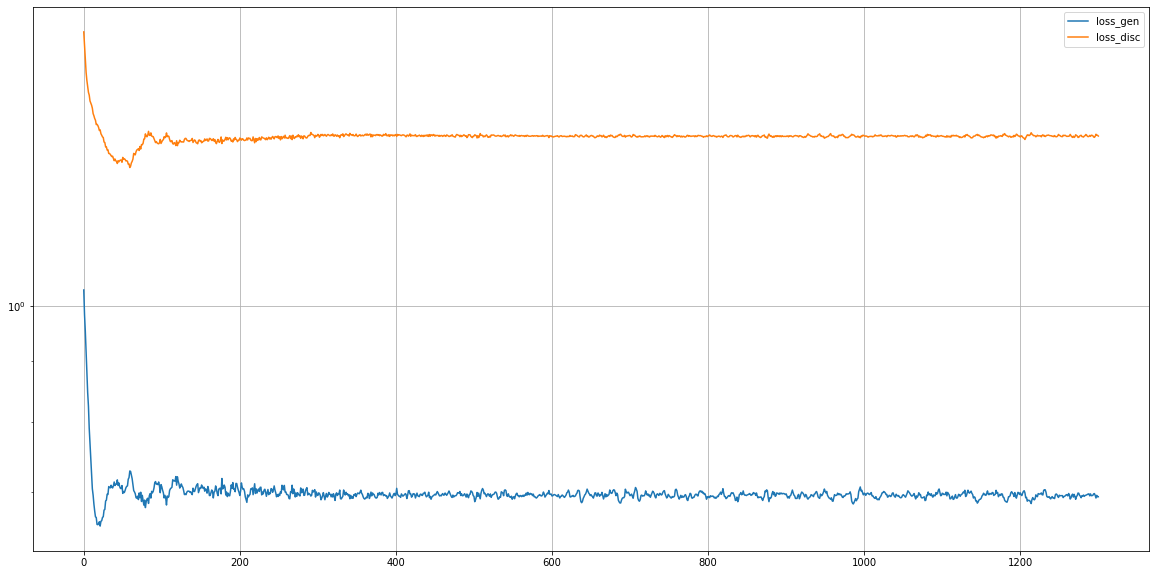

Epoch 1302/2000
Epoch 1303/2000
Epoch 1304/2000
Epoch 1305/2000
Epoch 1306/2000
Epoch 1307/2000
Epoch 1308/2000
Epoch 1309/2000
Epoch 1310/2000
Epoch 1311/2000
Epoch 1312/2000
Epoch 1313/2000
Epoch 1314/2000
Epoch 1315/2000
Epoch 1316/2000
Epoch 1317/2000
Epoch 1318/2000
Epoch 1319/2000
Epoch 1320/2000
Epoch 1321/2000
Epoch 1322/2000
Epoch 1323/2000
Epoch 1324/2000
Epoch 1325/2000
Epoch 1326/2000
Epoch 1327/2000
Epoch 1328/2000
Epoch 1329/2000
Epoch 1330/2000
Epoch 1331/2000
Epoch 1332/2000
Epoch 1333/2000
Epoch 1334/2000
Epoch 1335/2000
Epoch 1336/2000
Epoch 1337/2000
Epoch 1338/2000
Epoch 1339/2000
Epoch 1340/2000
Epoch 1341/2000
Epoch 1342/2000
Epoch 1343/2000
Epoch 1344/2000
Epoch 1345/2000
Epoch 1346/2000
Epoch 1347/2000
Epoch 1348/2000
Epoch 1349/2000
Epoch 1350/2000
Epoch 1351/2000
Epoch 1352/2000
Epoch 1353/2000
Epoch 1354/2000
Epoch 1355/2000
Epoch 1356/2000
Epoch 1357/2000
Epoch 1358/2000
Epoch 1359/2000
Epoch 1360/2000
Epoch 1361/2000
Epoch 1362/2000
Epoch 1363/2000
Epoch 13

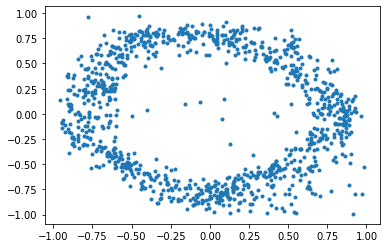

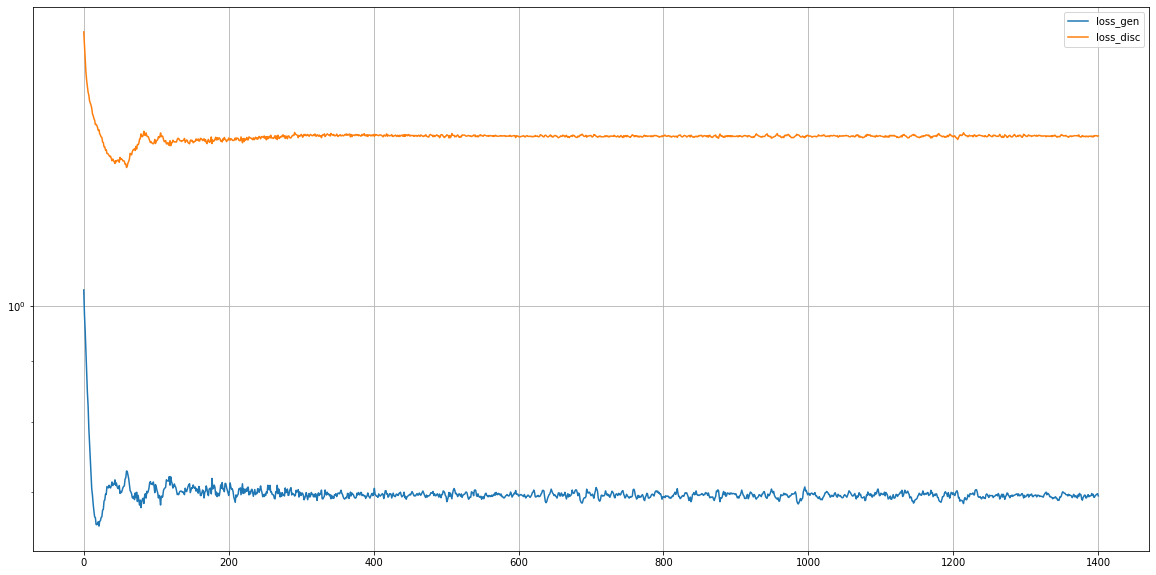

Epoch 1402/2000
Epoch 1403/2000
Epoch 1404/2000
Epoch 1405/2000
Epoch 1406/2000
Epoch 1407/2000
Epoch 1408/2000
Epoch 1409/2000
Epoch 1410/2000
Epoch 1411/2000
Epoch 1412/2000
Epoch 1413/2000
Epoch 1414/2000
Epoch 1415/2000
Epoch 1416/2000
Epoch 1417/2000
Epoch 1418/2000
Epoch 1419/2000
Epoch 1420/2000
Epoch 1421/2000
Epoch 1422/2000
Epoch 1423/2000
Epoch 1424/2000
Epoch 1425/2000
Epoch 1426/2000
Epoch 1427/2000
Epoch 1428/2000
Epoch 1429/2000
Epoch 1430/2000
Epoch 1431/2000
Epoch 1432/2000
Epoch 1433/2000
Epoch 1434/2000
Epoch 1435/2000
Epoch 1436/2000
Epoch 1437/2000
Epoch 1438/2000
Epoch 1439/2000
Epoch 1440/2000
Epoch 1441/2000
Epoch 1442/2000
Epoch 1443/2000
Epoch 1444/2000
Epoch 1445/2000
Epoch 1446/2000
Epoch 1447/2000
Epoch 1448/2000
Epoch 1449/2000
Epoch 1450/2000
Epoch 1451/2000
Epoch 1452/2000
Epoch 1453/2000
Epoch 1454/2000
Epoch 1455/2000
Epoch 1456/2000
Epoch 1457/2000
Epoch 1458/2000
Epoch 1459/2000
Epoch 1460/2000
Epoch 1461/2000
Epoch 1462/2000
Epoch 1463/2000
Epoch 14

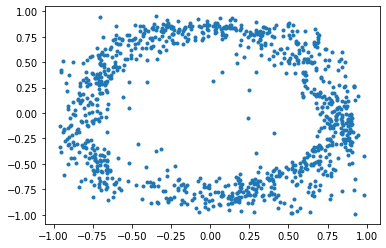

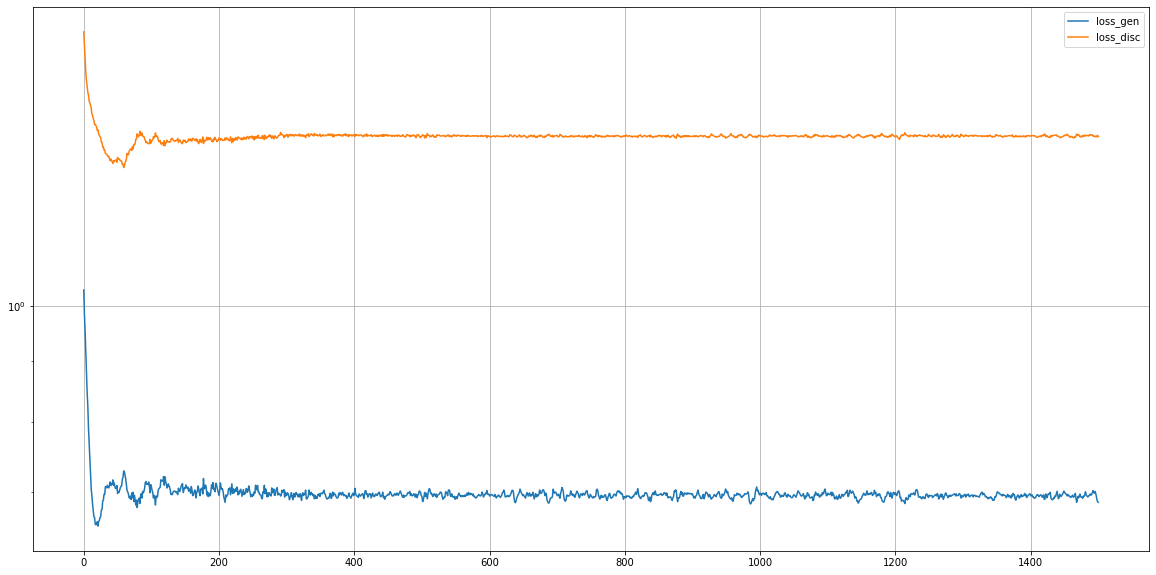

Epoch 1502/2000
Epoch 1503/2000
Epoch 1504/2000
Epoch 1505/2000
Epoch 1506/2000
Epoch 1507/2000
Epoch 1508/2000
Epoch 1509/2000
Epoch 1510/2000
Epoch 1511/2000
Epoch 1512/2000
Epoch 1513/2000
Epoch 1514/2000
Epoch 1515/2000
Epoch 1516/2000
Epoch 1517/2000
Epoch 1518/2000
Epoch 1519/2000
Epoch 1520/2000
Epoch 1521/2000
Epoch 1522/2000
Epoch 1523/2000
Epoch 1524/2000
Epoch 1525/2000
Epoch 1526/2000
Epoch 1527/2000
Epoch 1528/2000
Epoch 1529/2000
Epoch 1530/2000
Epoch 1531/2000
Epoch 1532/2000
Epoch 1533/2000
Epoch 1534/2000
Epoch 1535/2000
Epoch 1536/2000
Epoch 1537/2000
Epoch 1538/2000
Epoch 1539/2000
Epoch 1540/2000
Epoch 1541/2000
Epoch 1542/2000
Epoch 1543/2000
Epoch 1544/2000
Epoch 1545/2000
Epoch 1546/2000
Epoch 1547/2000
Epoch 1548/2000
Epoch 1549/2000
Epoch 1550/2000
Epoch 1551/2000
Epoch 1552/2000
Epoch 1553/2000
Epoch 1554/2000
Epoch 1555/2000
Epoch 1556/2000
Epoch 1557/2000
Epoch 1558/2000
Epoch 1559/2000
Epoch 1560/2000
Epoch 1561/2000
Epoch 1562/2000
Epoch 1563/2000
Epoch 15

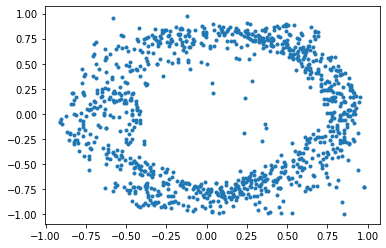

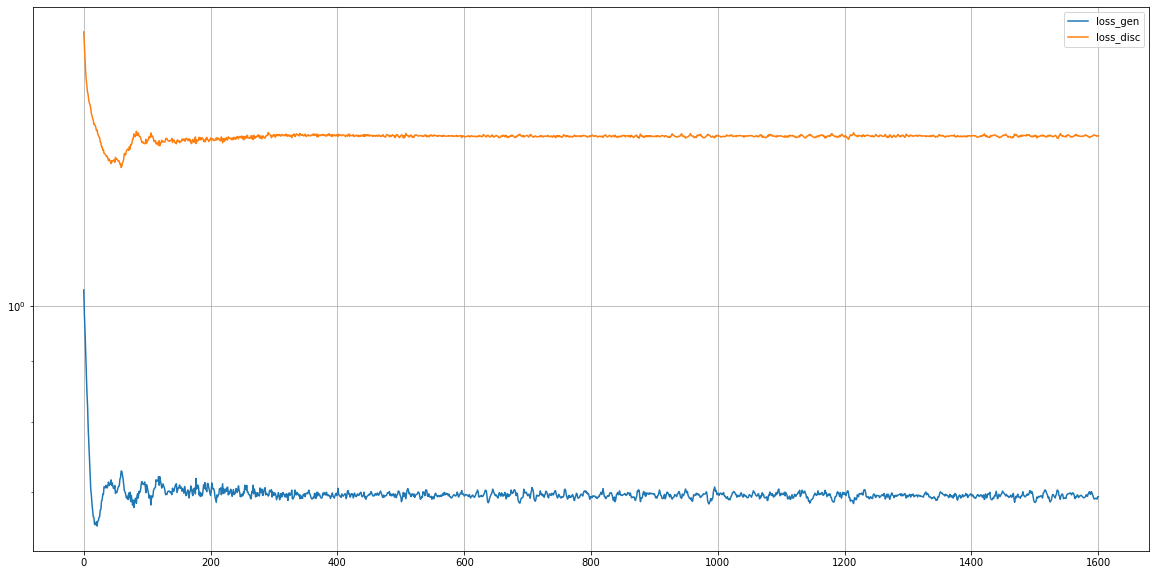

Epoch 1602/2000
Epoch 1603/2000
Epoch 1604/2000
Epoch 1605/2000
Epoch 1606/2000
Epoch 1607/2000
Epoch 1608/2000
Epoch 1609/2000
Epoch 1610/2000
Epoch 1611/2000
Epoch 1612/2000
Epoch 1613/2000
Epoch 1614/2000
Epoch 1615/2000
Epoch 1616/2000
Epoch 1617/2000
Epoch 1618/2000
Epoch 1619/2000
Epoch 1620/2000
Epoch 1621/2000
Epoch 1622/2000
Epoch 1623/2000
Epoch 1624/2000
Epoch 1625/2000
Epoch 1626/2000
Epoch 1627/2000
Epoch 1628/2000
Epoch 1629/2000
Epoch 1630/2000
Epoch 1631/2000
Epoch 1632/2000
Epoch 1633/2000
Epoch 1634/2000
Epoch 1635/2000
Epoch 1636/2000
Epoch 1637/2000
Epoch 1638/2000
Epoch 1639/2000
Epoch 1640/2000
Epoch 1641/2000
Epoch 1642/2000
Epoch 1643/2000
Epoch 1644/2000
Epoch 1645/2000
Epoch 1646/2000
Epoch 1647/2000
Epoch 1648/2000
Epoch 1649/2000
Epoch 1650/2000
Epoch 1651/2000
Epoch 1652/2000
Epoch 1653/2000
Epoch 1654/2000
Epoch 1655/2000
Epoch 1656/2000
Epoch 1657/2000
Epoch 1658/2000
Epoch 1659/2000
Epoch 1660/2000
Epoch 1661/2000
Epoch 1662/2000
Epoch 1663/2000
Epoch 16

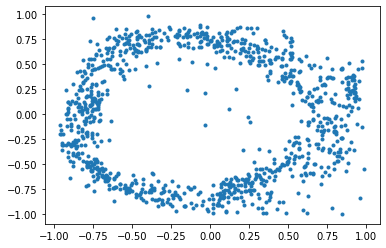

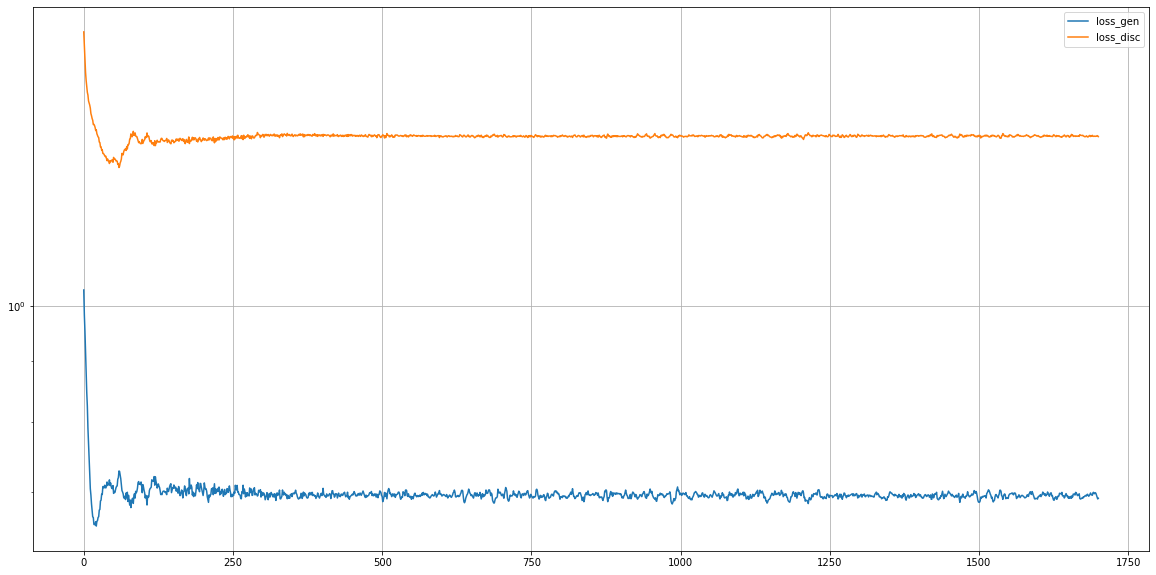

Epoch 1702/2000
Epoch 1703/2000
Epoch 1704/2000
Epoch 1705/2000
Epoch 1706/2000
Epoch 1707/2000
Epoch 1708/2000
Epoch 1709/2000
Epoch 1710/2000
Epoch 1711/2000
Epoch 1712/2000
Epoch 1713/2000
Epoch 1714/2000
Epoch 1715/2000
Epoch 1716/2000
Epoch 1717/2000
Epoch 1718/2000
Epoch 1719/2000
Epoch 1720/2000
Epoch 1721/2000
Epoch 1722/2000
Epoch 1723/2000
Epoch 1724/2000
Epoch 1725/2000
Epoch 1726/2000
Epoch 1727/2000
Epoch 1728/2000
Epoch 1729/2000
Epoch 1730/2000
Epoch 1731/2000
Epoch 1732/2000
Epoch 1733/2000
Epoch 1734/2000
Epoch 1735/2000
Epoch 1736/2000
Epoch 1737/2000
Epoch 1738/2000
Epoch 1739/2000
Epoch 1740/2000
Epoch 1741/2000
Epoch 1742/2000
Epoch 1743/2000
Epoch 1744/2000
Epoch 1745/2000
Epoch 1746/2000
Epoch 1747/2000
Epoch 1748/2000
Epoch 1749/2000
Epoch 1750/2000
Epoch 1751/2000
Epoch 1752/2000
Epoch 1753/2000
Epoch 1754/2000
Epoch 1755/2000
Epoch 1756/2000
Epoch 1757/2000
Epoch 1758/2000
Epoch 1759/2000
Epoch 1760/2000
Epoch 1761/2000
Epoch 1762/2000
Epoch 1763/2000
Epoch 17

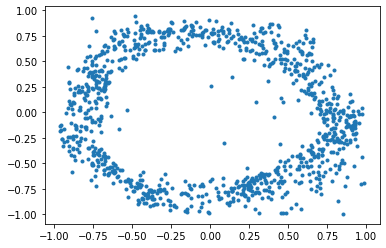

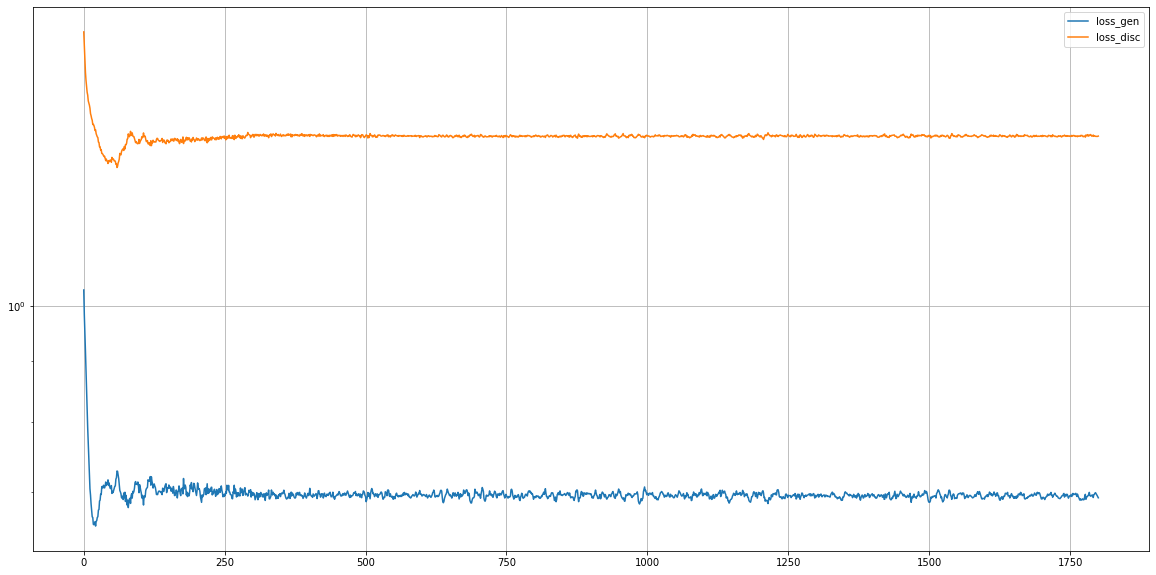

Epoch 1802/2000
Epoch 1803/2000
Epoch 1804/2000
Epoch 1805/2000
Epoch 1806/2000
Epoch 1807/2000
Epoch 1808/2000
Epoch 1809/2000
Epoch 1810/2000
Epoch 1811/2000
Epoch 1812/2000
Epoch 1813/2000
Epoch 1814/2000
Epoch 1815/2000
Epoch 1816/2000
Epoch 1817/2000
Epoch 1818/2000
Epoch 1819/2000
Epoch 1820/2000
Epoch 1821/2000
Epoch 1822/2000
Epoch 1823/2000
Epoch 1824/2000
Epoch 1825/2000
Epoch 1826/2000
Epoch 1827/2000
Epoch 1828/2000
Epoch 1829/2000
Epoch 1830/2000
Epoch 1831/2000
Epoch 1832/2000
Epoch 1833/2000
Epoch 1834/2000
Epoch 1835/2000
Epoch 1836/2000
Epoch 1837/2000
Epoch 1838/2000
Epoch 1839/2000
Epoch 1840/2000
Epoch 1841/2000
Epoch 1842/2000
Epoch 1843/2000
Epoch 1844/2000
Epoch 1845/2000
Epoch 1846/2000
Epoch 1847/2000
Epoch 1848/2000
Epoch 1849/2000
Epoch 1850/2000
Epoch 1851/2000
Epoch 1852/2000
Epoch 1853/2000
Epoch 1854/2000
Epoch 1855/2000
Epoch 1856/2000
Epoch 1857/2000
Epoch 1858/2000
Epoch 1859/2000
Epoch 1860/2000
Epoch 1861/2000
Epoch 1862/2000
Epoch 1863/2000
Epoch 18

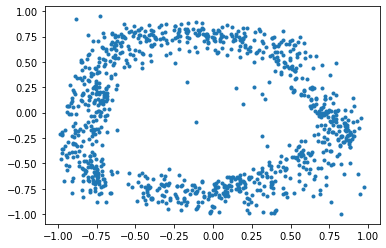

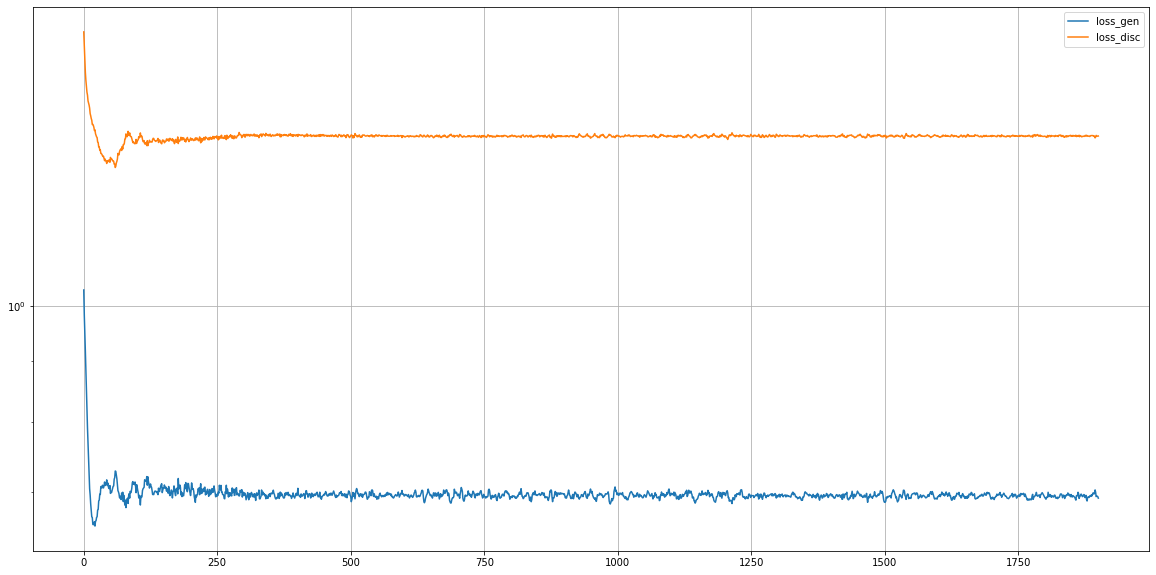

Epoch 1902/2000
Epoch 1903/2000
Epoch 1904/2000
Epoch 1905/2000
Epoch 1906/2000
Epoch 1907/2000
Epoch 1908/2000
Epoch 1909/2000
Epoch 1910/2000
Epoch 1911/2000
Epoch 1912/2000
Epoch 1913/2000
Epoch 1914/2000
Epoch 1915/2000
Epoch 1916/2000
Epoch 1917/2000
Epoch 1918/2000
Epoch 1919/2000
Epoch 1920/2000
Epoch 1921/2000
Epoch 1922/2000
Epoch 1923/2000
Epoch 1924/2000
Epoch 1925/2000
Epoch 1926/2000
Epoch 1927/2000
Epoch 1928/2000
Epoch 1929/2000
Epoch 1930/2000
Epoch 1931/2000
Epoch 1932/2000
Epoch 1933/2000
Epoch 1934/2000
Epoch 1935/2000
Epoch 1936/2000
Epoch 1937/2000
Epoch 1938/2000
Epoch 1939/2000
Epoch 1940/2000
Epoch 1941/2000
Epoch 1942/2000
Epoch 1943/2000
Epoch 1944/2000
Epoch 1945/2000
Epoch 1946/2000
Epoch 1947/2000
Epoch 1948/2000
Epoch 1949/2000
Epoch 1950/2000
Epoch 1951/2000
Epoch 1952/2000
Epoch 1953/2000
Epoch 1954/2000
Epoch 1955/2000
Epoch 1956/2000
Epoch 1957/2000
Epoch 1958/2000
Epoch 1959/2000
Epoch 1960/2000
Epoch 1961/2000
Epoch 1962/2000
Epoch 1963/2000
Epoch 19

In [ ]:
hist = train(train_dataset, epochs=2000)

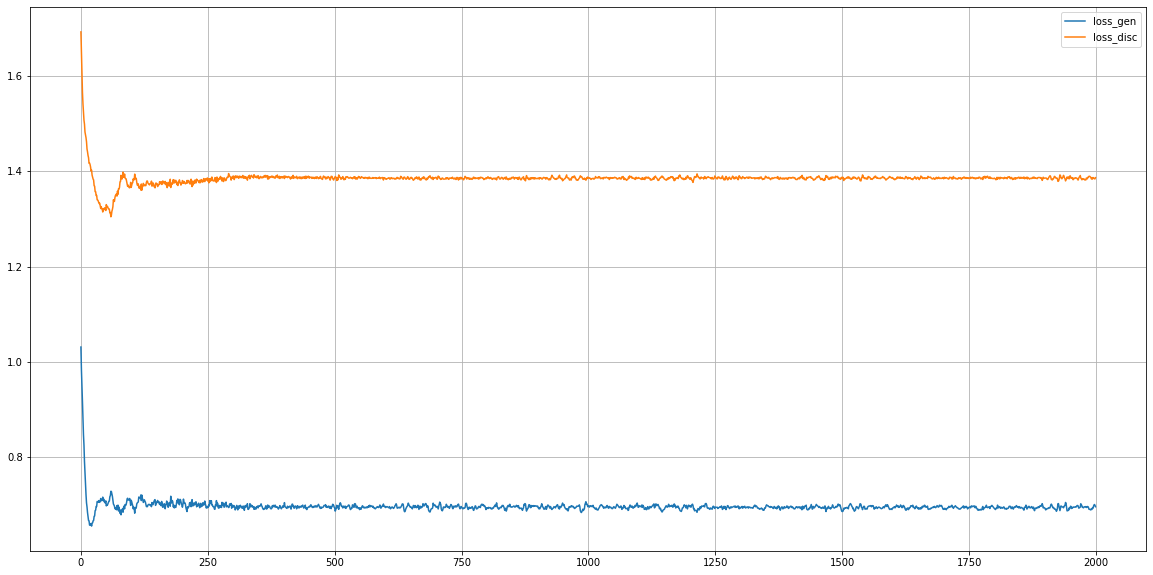

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['loss_gen', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()

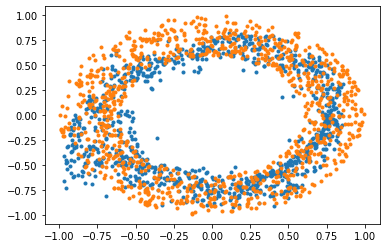

In [ ]:
generated_image = generator(noise, training=False)
#print(generated_image.shape)
plt.plot(generated_image[:,0], generated_image[:,1],'.')
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)
plt.plot(X_train, y_train, '.')

# Predict Fixed Input

In [ ]:
# latent_values = tf.random.normal([500, latent_space])
# predicted_values = generator.predict(latent_values)

In [ ]:
# plt.plot(predicted_values[:,0], predicted_values[:,1],'.')
# plt.plot(X_train, y_train, '.')

In [ ]:
num_fixed = 9
x_input = np.linspace(-4,4,num_fixed)
n_features = 2
n_points = num_fixed * 100

In [ ]:
predict_all = np.ndarray((n_points, n_features))

for i in range(num_fixed):
    predicted = np.full((n_points//9, n_features), x_input[i])
    predict_all[i*100:i*100+100, :] = predicted[:,:]

predict_all = scaler.fit_transform(predict_all)
input = predict_all.reshape(n_points, n_features).astype('float32')

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-2)

In [ ]:
def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, n_features])
    outp = tf.reshape(outp, [-1, n_features])
    
    return tf.reduce_mean(tf.math.squared_difference(inp[:,0], outp[:,0]))

In [ ]:
@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)
        loss = mse_loss(real_coding, gen_output)

    gradient = tape.gradient(loss, latent_values)
    optimizer.apply_gradients(zip([gradient], [latent_values]))

    return loss

In [ ]:
def optimize_coding(real_coding):
    latent_values = tf.random.normal([len(real_coding), latent_space])
    latent_values = tf.Variable(latent_values)
    
    loss = []
    for epoch in range(1000):
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show
        
    return latent_values

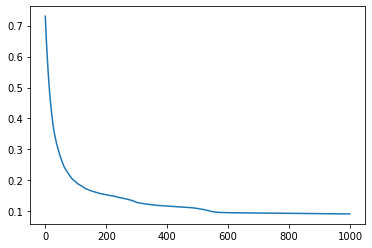

In [ ]:
latent_values = optimize_coding(input)

predicted_vals = generator.predict(tf.convert_to_tensor(latent_values)).reshape(len(input), n_features)
predicted_vals = predicted_vals.reshape(len(input), n_features)

X_generated = predicted_vals[1:,:]

Generated Data: (899, 2)


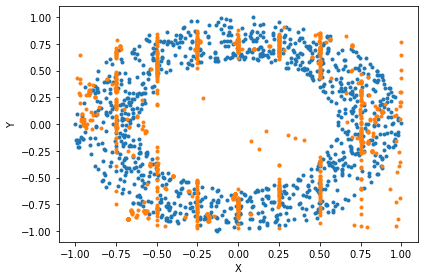

In [ ]:
print("Generated Data:",X_generated.shape)
plt.plot(X_train, y_train,'.')
plt.plot(X_generated[:,0],X_generated[:,1],'.')
plt.ylabel('Y')
plt.xlabel('X')
plt.tight_layout()